In [ ]:
# switch to TPU!!!
!pip install "jax[tpu]>=0.4.16" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
import jax
import jax.numpy as jnp
import jax.random as jr
from functools import partial
import time
import pandas as pd
from pathlib import Path
from scipy.linalg import orth # For creating orthogonal matrices
import numpy as np
from jax import vmap
import csv
import os
from datetime import datetime

# 
jax.config.update('jax_enable_x64', False)
jax.config.update('jax_default_matmul_precision', 'tensorfloat32')

class UltraBKNC:
    def __init__(self, k=10, lambda_=0.1, niter=25, seed=42, group_size=2):
        self.k = k
        self.lambda_ = lambda_
        self.lambda_reformed = (1-lambda_)/lambda_
        self.niter = niter
        self.seed = seed
        self.dtype = jnp.bfloat16
        self.tpu_tile = 256
        self.runtime_ = None
        self.test_runtime_ = None

        self.sse_ = None
        self.balance_loss_ = None
        self.centroids_ = None

        self.F_ = None  #  F 
        self.Y_ = None  #  Y 
        self.R_ = None  #  R 

        # 
        self._orth = staticmethod(jax.jit(partial(jnp.linalg.qr, mode='reduced')))
        self._svd = staticmethod(jax.jit(partial(jnp.linalg.svd, full_matrices=False)))
        self._matmul = staticmethod(jax.jit(jnp.matmul))

        # 
        self._buffers = None

        self.group_size = group_size

    def _alloc_buffers(self, n_samples):
        """"""
        self._buffers = {
            'F': jnp.empty((n_samples, self.k), dtype=self.dtype),
            'G': jnp.empty((n_samples, self.k), dtype=self.dtype),
            'M': jnp.empty((n_samples, self.k), dtype=self.dtype)  # (n_samples, k)
        }

    def _init_params(self, n_samples):
        """"""
        key = jr.PRNGKey(self.seed)
        keys = jr.split(key, 3)

        # Y
        Y = jax.nn.one_hot(
            jr.randint(keys[0], (n_samples,), 0, self.k),
            self.k, dtype=self.dtype
        )

        # R
        R = self._orth(jr.uniform(keys[1], (self.k, self.k), dtype=self.dtype))[0]
        return Y, R


    @partial(jax.jit, static_argnums=(0,))
    # def predict(self, X_new):
    #     """ F, Y, R  X_new """
    #     X_new = jnp.array(X_new, dtype=self.dtype)
    #     n_new = X_new.shape[0]

    #     #  F_new（）
    #     key = jr.PRNGKey(self.seed)
    #     F_new = self._orth(jr.uniform(key, (n_new, self.k), dtype=self.dtype))[0]

    #     #  Y_new（ R）
    #     P_new = jnp.dot(self.R_.T, F_new.T)  # (k, k) × (k, n_new) → (k, n_new)
    #     Y_new = jax.nn.one_hot(jnp.argmax(P_new, axis=0), self.k, dtype=self.dtype)

    #     # 
    #     labels_new = jnp.argmax(Y_new, axis=1)
    #     return labels_new, F_new, Y_new
    def predict(self, X_new):
        """（）"""
        X_new = jnp.array(X_new, dtype=self.dtype)
        n_new = X_new.shape[0]

        # （）
        key = jr.PRNGKey(self.seed)

        # （）
        start_time = time.time()

        # 1.  F_new 
        F_new = self._orth(jr.uniform(key, (n_new, self.k), dtype=self.dtype))[0]

        # 2.  Y_new = argmax(R^T @ F_new^T)
        P_new = jnp.dot(self.R_.T, F_new.T)  # (k, n_new)
        Y_new = jax.nn.one_hot(jnp.argmax(P_new, axis=0), self.k, dtype=self.dtype)

        # 3. 
        labels_new = jnp.argmax(Y_new, axis=1)

        runtime = time.time() - start_time
        self.test_runtime_ = runtime

        return labels_new, F_new, Y_new

    @partial(jax.jit, static_argnums=(0,))
    def _core_iteration(self, X_m, Y, R, key):
        """"""
        # 1. F
        key, f_key = jr.split(key)
        F = self._buffers['F'].at[:].set(
            self._orth(jr.uniform(f_key, self._buffers['F'].shape, dtype=self.dtype))[0]
        )

        # 2. G
        G = self._buffers['G'].at[:].set(jnp.dot(Y, R.T))  # (n_samples, k)

        # 3. 
        def _inner(F, _):
            XF = jnp.dot(X_m, F)  # (n_features, n_samples) × (n_samples, k) → (n_features, k)
            term1 = 2 * jnp.dot(X_m.T, XF)  # (n_samples, n_features) × (n_features, k) → (n_samples, k)
            term2 = self.lambda_reformed * G  # (n_samples, k)
            M = self._buffers['M'].at[:].set(term1 + term2)  # ，(n_samples, k)
            U, _, Vh = self._svd(M)
            return jnp.dot(U, Vh), None

        F, _ = jax.lax.scan(_inner, F, None, length=3)

        # 4. R
        U_r, _, Vh_r = self._svd(jnp.dot(F.T, Y))  # (k, n_samples) × (n_samples, k) → (k, k)
        R_new = jnp.dot(U_r, Vh_r)

        # 5. Y
        P_calc_Y = jnp.dot(R_new.T, F.T)  # (k, k) × (k, n_samples) → (k, n_samples)
        # Y_new = jax.nn.one_hot(
        #     jnp.argmax(P_calc_Y, axis=0),  # 
        #     self.k, dtype=self.dtype
        # )
        #  P_calc_Y  (num_rows // n, n, k)
        n = self.group_size
        n_samples = P_calc_Y.shape[1]  # 
        # ，
        if n_samples % n != 0:
            pad_size = n - (n_samples % n)
            P_calc_Y = jnp.pad(P_calc_Y, [(0,0), (0,pad_size)])
            n_samples = P_calc_Y.shape[1]
        reshaped_P = P_calc_Y.reshape(-1, n, self.k)

        # n（n）
        product_P = jnp.prod(reshaped_P, axis=1)  #  (num_rows // n, k)

        # 
        max_indices = jnp.argmax(product_P, axis=-1)  #  (num_rows // n,)

        # one-hot
        Y_new = jax.nn.one_hot(
            max_indices,
            self.k,
            dtype=self.dtype
        )

        # （none-hot）
        Y_new_expanded = jnp.repeat(Y_new, n, axis=0)  # P_calc_Y

        # ，
        Y_new_expanded = Y_new_expanded[:P_calc_Y.shape[1]]

        return Y_new_expanded, R_new, key

    def train(self, X):
        # 
        X = jnp.array(X, dtype=self.dtype)
        orig_size = X.shape[0]

        # 
        pad_size = (self.tpu_tile - orig_size % self.tpu_tile) % self.tpu_tile
        X_padded = jnp.pad(X, [(0, pad_size), (0,0)])
        X_m = X_padded.T

        # 
        self._alloc_buffers(X_padded.shape[0])
        Y, R = self._init_params(X_padded.shape[0])
        key = jr.PRNGKey(self.seed)

        # 
        _ = self._core_iteration(X_m, Y, R, key)

        # 
        start = time.time()
        for _ in range(self.niter):
            Y, R, key = self._core_iteration(X_m, Y, R, key)

        self.runtime_ = time.time() - start
        #  F, Y, R
        self.F_ = self._buffers['F'][:orig_size]  # 
        self.Y_ = Y[:orig_size] # 
        self.R_ = R # R  (k, k)，

        self.labels_ = jnp.argmax(Y[:orig_size], axis=1)

        X_original = X[:orig_size]  # 
        labels_np = np.array(self.labels_)  #  NumPy 

        #  centroids_
        centroids = []
        for cluster_idx in range(self.k):
            cluster_points = X_original[labels_np == cluster_idx]  # 
            if len(cluster_points) > 0:
                centroid = np.mean(cluster_points, axis=0)  # 
            else:
                centroid = np.zeros(X_original.shape[1])  #  0
            centroids.append(centroid)
        self.centroids_ = np.array(centroids)  # (k, n_features)

        #  SSE
        sse = 0.0
        for i in range(orig_size):
            cluster_idx = labels_np[i]
            point = X_original[i]
            centroid = self.centroids_[cluster_idx]
            sse += np.sum((point - centroid) ** 2)  # 
        self.sse_ = float(sse)

        #  Balance Loss
        cluster_sizes = np.bincount(labels_np, minlength=self.k)
        ideal_size = orig_size / self.k
        self.balance_loss_ = float(np.sum((cluster_sizes - ideal_size) ** 2))

        return self

def run_experiment(train_path, test_path, dimensions, n_clusters, group_size):
    """：+，"""
    # 1.  (10K)
    X_train = pd.read_csv(train_path, header=None).values.astype(jnp.float32)

    # 2. （10K）
    model = UltraBKNC(k=n_clusters, lambda_=0.1, niter=10, seed=42, group_size=group_size)
    model.train(X_train)  # SSEBalance Loss

    # 3. 
    train_metrics = {
        "train_runtime": model.runtime_,
        "train_sse": model.sse_,
        "train_balance_loss": model.balance_loss_,
    }

    # 4.  (1K)
    X_test = pd.read_csv(test_path, header=None).values.astype(jnp.float32)

    # 5. 
    test_labels, F_test, Y_test = model.predict(X_test)

    # 6. SSEBalance Loss
    # ：centroids_SSE
    sse_test = 0.0
    for i in range(X_test.shape[0]):
        cluster_idx = test_labels[i]
        point = X_test[i]
        centroid = model.centroids_[cluster_idx]  # 
        sse_test += jnp.sum((point - centroid) ** 2)

    # Balance Loss
    cluster_sizes_test = np.bincount(test_labels, minlength=n_clusters)
    ideal_size_test = X_test.shape[0] / n_clusters
    balance_loss_test = np.sum((cluster_sizes_test - ideal_size_test) ** 2)

    # 7. （+）
    total_samples = X_train.shape[0] + X_test.shape[0]

    # SSE = SSE + SSE
    total_sse = model.sse_ + sse_test

    # Balance Loss（）
    combined_cluster_sizes = cluster_sizes_test + np.bincount(model.labels_, minlength=n_clusters)
    ideal_size_total = total_samples / n_clusters
    total_balance_loss = np.sum((combined_cluster_sizes - ideal_size_total) ** 2)

    # 8. 
    return {
        # 
        **train_metrics,
        # 
        "test_runtime": model.test_runtime_,
        "test_sse": float(sse_test),
        "test_balance_loss": float(balance_loss_test),
        # 
        "total_sse": float(total_sse),
        "total_balance_loss": float(total_balance_loss),
        # 
        "cluster_distribution_train": np.bincount(model.labels_, minlength=n_clusters),
        "cluster_distribution_test": cluster_sizes_test
    }

if __name__ == '__main__':
    #  (10K)  (1K) 
    datasets = [
        {
            "name": "Huatuo",
            "train": "/content/sample_data/Huatuo_1024d_10k.csv",
            "test": "/content/sample_data/Huatuo_1024d_1k.csv",
            "dim": 1024
        },
        {
            "name": "LiveChat",
            "train": "/content/sample_data/LiveChat_1024d_10k.csv",
            "test": "/content/sample_data/LiveChat_1024d_1k.csv",
            "dim": 1024
        },
        {
            "name": "deep",
            "train": "/content/sample_data/deep_96d_10k.csv",
            "test": "/content/sample_data/deep_96d_1k.csv",
            "dim": 96
        },
        {
            "name": "glove",
            "train": "/content/sample_data/glove_300d_10k.csv",
            "test": "/content/sample_data/glove_300d_1k.csv",
            "dim": 300
        },
        {
            "name": "sift",
            "train": "/content/sample_data/sift_128d_10k.csv",
            "test": "/content/sample_data/sift_128d_1k.csv",
            "dim": 128
        }
    ]
    group_sizes = [1, 2, 8, 32, 64]

    # CSV
    csv_file = "TubmeansUpdateStrategy.csv"
    with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Dataset", "Group Size", "Runtime (s)", "SSE", "Balance Loss"])

        for data in datasets:
            for n in group_sizes:
                print(f"\n=== : {data['name']}, Group Size: {n} ===")
                results = run_experiment(
                    train_path=data["train"],
                    test_path=data["test"],
                    dimensions=data["dim"],
                    n_clusters=10,
                    group_size=n,
                )

                # （）
                writer.writerow([
                    data['name'],
                    n,
                    results['test_runtime'],
                    results['total_sse'],
                    results['total_balance_loss']
                ])

    print(f"\n {csv_file}")

Looking in links: https://storage.googleapis.com/jax-releases/libtpu_releases.html

=== : Huatuo, Group Size: 1 ===

=== : Huatuo, Group Size: 2 ===

=== : Huatuo, Group Size: 8 ===

=== : Huatuo, Group Size: 32 ===

=== : Huatuo, Group Size: 64 ===

=== : LiveChat, Group Size: 1 ===

=== : LiveChat, Group Size: 2 ===

=== : LiveChat, Group Size: 8 ===

=== : LiveChat, Group Size: 32 ===

=== : LiveChat, Group Size: 64 ===

=== : deep, Group Size: 1 ===

=== : deep, Group Size: 2 ===

=== : deep, Group Size: 8 ===

=== : deep, Group Size: 32 ===

=== : deep, Group Size: 64 ===

=== : glove, Group Size: 1 ===

=== : glove, Group Size: 2 ===

=== : glove, Group Size: 8 ===

=== : glove, Group Size: 32 ===

=== : glove, Group Size: 64 ===

=== : sift, Group Size: 1 ===

=== : sift, Group Size: 2 ===

=== : sift, Group Size: 8 ===

=== : sift, Group Size: 32 ===

=== : sift, Group Size: 64 ===

 TubmeansUpdateStrategy.csv


In [ ]:
import pandas as pd
import numpy as np

# 1️⃣  CSV
df = pd.read_csv('TubmeansUpdateStrategy.csv')

# 2️⃣  Dataset  Model 
df['Dataset_raw'] = df['Dataset'].str.split('-').str[0].str.split('_').str[0]
df['Model_raw'] = df['Group Size']

# 3️⃣  Dataset  Model 
df['Dataset'] = df['Dataset_raw'].replace({
    'deep': 'Deep',
    'sift': 'SIFT',
    'glove': 'GloVe'
})

# 4️⃣  CSV  Dataset  Categorical
dataset_order = df.drop_duplicates('Dataset_raw')['Dataset'].tolist()
df['Dataset'] = pd.Categorical(df['Dataset'], categories=dataset_order, ordered=True)

# 5️⃣ （ Model ）
df['row_order'] = np.arange(len(df))

# 6️⃣  Dataset、 
df = df.sort_values(['Dataset', 'row_order']).drop(columns=['row_order', 'Dataset_raw', 'Model_raw'])

# ✅ 
def format_row(dataset, model, clasteringloss, balanceloss, runtime, last=False, multirow=False, multirow_count=None):
    clasteringloss = "{:.2E}".format(clasteringloss)
    balanceloss = "{:.2E}".format(balanceloss)
    runtime = "{:.2E}".format(runtime)

    if multirow:
        row = f"\\multirow{{{multirow_count}}}{{*}}{{\\ {dataset}}}\n& \\ {model} & {clasteringloss} & {balanceloss} & {runtime} \\\\"
    elif last:
        row = f"& \\ {model} & {clasteringloss} & {balanceloss} & {runtime} \\\\ \\midrule \n"
    else:
        row = f"& \\ {model} & {clasteringloss} & {balanceloss} & {runtime} \\\\"
    return row

# 7️⃣ 
lines = []
for dataset, group in df.groupby('Dataset'):
    models = group['Group Size'].tolist()
    clasteringloss = group['SSE'].tolist()
    balanceloss = group['Balance Loss'].tolist()
    runtime = group['Runtime (s)'].tolist()

    for i in range(len(models)):
        is_first = (i == 0)
        is_last = (i == len(models) - 1)  # 
        line = format_row(dataset, models[i], clasteringloss[i], balanceloss[i], runtime[i],
                          last=is_last, multirow=is_first, multirow_count=len(models) if is_first else None)
        lines.append(line)

# 8️⃣ 
latex_table_body = "\n".join(lines)
print(latex_table_body)

with open("latex_table_rows.tex", "w") as f:
    f.write(latex_table_body)

\multirow{5}{*}{\ Huatuo}
& \ 1 & 5.26E+02 & 3.11E+04 & 1.88E-03 \\
& \ 2 & 5.30E+02 & 4.20E+04 & 1.80E-03 \\
& \ 8 & 5.27E+02 & 1.14E+05 & 1.79E-03 \\
& \ 32 & 3.98E+03 & 9.27E+07 & 1.80E-03 \\
& \ 64 & 3.98E+03 & 9.27E+07 & 2.13E-03 \\ \midrule 

\multirow{5}{*}{\ LiveChat}
& \ 1 & 3.31E+02 & 4.96E+04 & 1.93E-03 \\
& \ 2 & 3.31E+02 & 3.33E+04 & 1.82E-03 \\
& \ 8 & 3.31E+02 & 5.81E+04 & 1.79E-03 \\
& \ 32 & 2.87E+03 & 9.22E+07 & 1.79E-03 \\
& \ 64 & 2.87E+03 & 9.22E+07 & 1.85E-03 \\ \midrule 

\multirow{5}{*}{\ Deep}
& \ 1 & 1.44E+03 & 9.81E+03 & 1.75E-03 \\
& \ 2 & 1.44E+03 & 3.77E+04 & 1.85E-03 \\
& \ 8 & 1.44E+03 & 1.13E+05 & 1.86E-03 \\
& \ 32 & 1.03E+04 & 9.23E+07 & 1.97E-03 \\
& \ 64 & 1.03E+04 & 9.23E+07 & 1.75E-03 \\ \midrule 

\multirow{5}{*}{\ GloVe}
& \ 1 & 7.77E+04 & 2.34E+04 & 1.73E-03 \\
& \ 2 & 7.80E+04 & 1.97E+04 & 1.86E-03 \\
& \ 8 & 7.80E+04 & 5.14E+04 & 1.92E-03 \\
& \ 32 & 4.32E+05 & 9.25E+07 & 1.72E-03 \\
& \ 64 & 4.32E+05 & 9.25E+07 & 1.77E-03 \\ \midrule 

\mult

/tmp/ipython-input-50-436854619.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for dataset, group in df.groupby('Dataset'):


In [ ]:
# runtime
# switch to TPU!!!
!pip install "jax[tpu]>=0.4.16" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
import jax
import jax.numpy as jnp
import jax.random as jr
from functools import partial
import time
import pandas as pd
from pathlib import Path
from scipy.linalg import orth # For creating orthogonal matrices
import numpy as np
from jax import vmap
import csv
import os
from datetime import datetime

# 
jax.config.update('jax_enable_x64', False)
jax.config.update('jax_default_matmul_precision', 'tensorfloat32')

class UltraBKNC:
    def __init__(self, k=10, lambda_=0.1, niter=25, seed=42, group_size=2):
        self.k = k
        self.lambda_ = lambda_
        self.lambda_reformed = (1-lambda_)/lambda_
        self.niter = niter
        self.seed = seed
        self.dtype = jnp.bfloat16
        self.tpu_tile = 256
        self.runtime_ = None
        self.test_runtime_ = None

        self.sse_ = None
        self.balance_loss_ = None
        self.centroids_ = None

        self.F_ = None  #  F 
        self.Y_ = None  #  Y 
        self.R_ = None  #  R 

        # 
        self._orth = staticmethod(jax.jit(partial(jnp.linalg.qr, mode='reduced')))
        self._svd = staticmethod(jax.jit(partial(jnp.linalg.svd, full_matrices=False)))
        self._matmul = staticmethod(jax.jit(jnp.matmul))

        # 
        self._buffers = None

        self.group_size = group_size

    def _alloc_buffers(self, n_samples):
        """"""
        self._buffers = {
            'F': jnp.empty((n_samples, self.k), dtype=self.dtype),
            'G': jnp.empty((n_samples, self.k), dtype=self.dtype),
            'M': jnp.empty((n_samples, self.k), dtype=self.dtype)  # (n_samples, k)
        }

    def _init_params(self, n_samples):
        """"""
        key = jr.PRNGKey(self.seed)
        keys = jr.split(key, 3)

        # Y
        Y = jax.nn.one_hot(
            jr.randint(keys[0], (n_samples,), 0, self.k),
            self.k, dtype=self.dtype
        )

        # R
        R = self._orth(jr.uniform(keys[1], (self.k, self.k), dtype=self.dtype))[0]
        return Y, R


    @partial(jax.jit, static_argnums=(0,))
    # def predict(self, X_new):
    #     """ F, Y, R  X_new """
    #     X_new = jnp.array(X_new, dtype=self.dtype)
    #     n_new = X_new.shape[0]

    #     #  F_new（）
    #     key = jr.PRNGKey(self.seed)
    #     F_new = self._orth(jr.uniform(key, (n_new, self.k), dtype=self.dtype))[0]

    #     #  Y_new（ R）
    #     P_new = jnp.dot(self.R_.T, F_new.T)  # (k, k) × (k, n_new) → (k, n_new)
    #     Y_new = jax.nn.one_hot(jnp.argmax(P_new, axis=0), self.k, dtype=self.dtype)

    #     # 
    #     labels_new = jnp.argmax(Y_new, axis=1)
    #     return labels_new, F_new, Y_new
    def predict(self, X_new):
        """（）"""
        X_new = jnp.array(X_new, dtype=self.dtype)
        n_new = X_new.shape[0]

        # （）
        key = jr.PRNGKey(self.seed)

        # （）
        start_time = time.time()

        # 1.  F_new 
        F_new = self._orth(jr.uniform(key, (n_new, self.k), dtype=self.dtype))[0]

        # 2.  Y_new = argmax(R^T @ F_new^T)
        P_new = jnp.dot(self.R_.T, F_new.T)  # (k, n_new)
        Y_new = jax.nn.one_hot(jnp.argmax(P_new, axis=0), self.k, dtype=self.dtype)

        # 3. 
        labels_new = jnp.argmax(Y_new, axis=1)

        runtime = time.time() - start_time
        self.test_runtime_ = runtime

        return labels_new, F_new, Y_new

    @partial(jax.jit, static_argnums=(0,))
    def _core_iteration(self, X_m, Y, R, key):
        """"""
        # 1. F
        key, f_key = jr.split(key)
        F = self._buffers['F'].at[:].set(
            self._orth(jr.uniform(f_key, self._buffers['F'].shape, dtype=self.dtype))[0]
        )

        # 2. G
        G = self._buffers['G'].at[:].set(jnp.dot(Y, R.T))  # (n_samples, k)

        # 3. 
        def _inner(F, _):
            XF = jnp.dot(X_m, F)  # (n_features, n_samples) × (n_samples, k) → (n_features, k)
            term1 = 2 * jnp.dot(X_m.T, XF)  # (n_samples, n_features) × (n_features, k) → (n_samples, k)
            term2 = self.lambda_reformed * G  # (n_samples, k)
            M = self._buffers['M'].at[:].set(term1 + term2)  # ，(n_samples, k)
            U, _, Vh = self._svd(M)
            return jnp.dot(U, Vh), None

        F, _ = jax.lax.scan(_inner, F, None, length=3)

        # 4. R
        U_r, _, Vh_r = self._svd(jnp.dot(F.T, Y))  # (k, n_samples) × (n_samples, k) → (k, k)
        R_new = jnp.dot(U_r, Vh_r)

        # 5. Y
        P_calc_Y = jnp.dot(R_new.T, F.T)  # (k, k) × (k, n_samples) → (k, n_samples)
        # Y_new = jax.nn.one_hot(
        #     jnp.argmax(P_calc_Y, axis=0),  # 
        #     self.k, dtype=self.dtype
        # )
        #  P_calc_Y  (num_rows // n, n, k)
        n = self.group_size
        n_samples = P_calc_Y.shape[1]  # 
        # ，
        if n_samples % n != 0:
            pad_size = n - (n_samples % n)
            P_calc_Y = jnp.pad(P_calc_Y, [(0,0), (0,pad_size)])
            n_samples = P_calc_Y.shape[1]
        reshaped_P = P_calc_Y.reshape(-1, n, self.k)

        # n（n）
        product_P = jnp.prod(reshaped_P, axis=1)  #  (num_rows // n, k)

        # 
        max_indices = jnp.argmax(product_P, axis=-1)  #  (num_rows // n,)

        # one-hot
        Y_new = jax.nn.one_hot(
            max_indices,
            self.k,
            dtype=self.dtype
        )

        # （none-hot）
        Y_new_expanded = jnp.repeat(Y_new, n, axis=0)  # P_calc_Y

        # ，
        Y_new_expanded = Y_new_expanded[:P_calc_Y.shape[1]]

        return Y_new_expanded, R_new, key

    def train(self, X):
        # 
        X = jnp.array(X, dtype=self.dtype)
        orig_size = X.shape[0]

        # 
        pad_size = (self.tpu_tile - orig_size % self.tpu_tile) % self.tpu_tile
        X_padded = jnp.pad(X, [(0, pad_size), (0,0)])
        X_m = X_padded.T

        # 
        self._alloc_buffers(X_padded.shape[0])
        Y, R = self._init_params(X_padded.shape[0])
        key = jr.PRNGKey(self.seed)

        # 
        _ = self._core_iteration(X_m, Y, R, key)

        # 
        start = time.time()
        for _ in range(self.niter):
            Y, R, key = self._core_iteration(X_m, Y, R, key)

        self.runtime_ = time.time() - start
        #  F, Y, R
        self.F_ = self._buffers['F'][:orig_size]  # 
        self.Y_ = Y[:orig_size] # 
        self.R_ = R # R  (k, k)，

        self.labels_ = jnp.argmax(Y[:orig_size], axis=1)

        X_original = X[:orig_size]  # 
        labels_np = np.array(self.labels_)  #  NumPy 

        #  centroids_
        centroids = []
        for cluster_idx in range(self.k):
            cluster_points = X_original[labels_np == cluster_idx]  # 
            if len(cluster_points) > 0:
                centroid = np.mean(cluster_points, axis=0)  # 
            else:
                centroid = np.zeros(X_original.shape[1])  #  0
            centroids.append(centroid)
        self.centroids_ = np.array(centroids)  # (k, n_features)

        #  SSE
        sse = 0.0
        for i in range(orig_size):
            cluster_idx = labels_np[i]
            point = X_original[i]
            centroid = self.centroids_[cluster_idx]
            sse += np.sum((point - centroid) ** 2)  # 
        self.sse_ = float(sse)

        #  Balance Loss
        cluster_sizes = np.bincount(labels_np, minlength=self.k)
        ideal_size = orig_size / self.k
        self.balance_loss_ = float(np.sum((cluster_sizes - ideal_size) ** 2))

        return self

def run_experiment(train_path, test_path, dimensions, n_clusters, group_size):
    """：+，"""
    # 1.  (10K)
    X_train = pd.read_csv(train_path, header=None).values.astype(jnp.float32)

    # 2. （10K）
    model = UltraBKNC(k=n_clusters, lambda_=0.1, niter=10, seed=42, group_size=group_size)
    model.train(X_train)  # SSEBalance Loss

    # 3. 
    train_metrics = {
        "train_runtime": model.runtime_,
        "train_sse": model.sse_,
        "train_balance_loss": model.balance_loss_,
    }

    # 4.  (1K)
    X_test = pd.read_csv(test_path, header=None).values.astype(jnp.float32)

    # 5. 
    test_labels, F_test, Y_test = model.predict(X_test)

    # 6. SSEBalance Loss
    # ：centroids_SSE
    sse_test = 0.0
    for i in range(X_test.shape[0]):
        cluster_idx = test_labels[i]
        point = X_test[i]
        centroid = model.centroids_[cluster_idx]  # 
        sse_test += jnp.sum((point - centroid) ** 2)

    # Balance Loss
    cluster_sizes_test = np.bincount(test_labels, minlength=n_clusters)
    ideal_size_test = X_test.shape[0] / n_clusters
    balance_loss_test = np.sum((cluster_sizes_test - ideal_size_test) ** 2)

    # 7. （+）
    total_samples = X_train.shape[0] + X_test.shape[0]

    # SSE = SSE + SSE
    total_sse = model.sse_ + sse_test

    # Balance Loss（）
    combined_cluster_sizes = cluster_sizes_test + np.bincount(model.labels_, minlength=n_clusters)
    ideal_size_total = total_samples / n_clusters
    total_balance_loss = np.sum((combined_cluster_sizes - ideal_size_total) ** 2)

    # 8. 
    return {
        # 
        **train_metrics,
        # 
        "test_runtime": model.test_runtime_,
        "test_sse": float(sse_test),
        "test_balance_loss": float(balance_loss_test),
        # 
        "total_sse": float(total_sse),
        "total_balance_loss": float(total_balance_loss),
        # 
        "cluster_distribution_train": np.bincount(model.labels_, minlength=n_clusters),
        "cluster_distribution_test": cluster_sizes_test
    }

if __name__ == '__main__':
    # 
    DATASET_ORDER = ['Huatuo', 'LiveChat', 'deep', 'glove', 'sift']
    SIZE_ORDER = ['100', '500', '1k', '2k', '5k']

    #  (10K)  (1K) 
    datasets = [
        {
            "name": "Huatuo",
            "train": "/content/sample_data/Huatuo_1024d_10k.csv",
            "test1": "/content/sample_data/Huatuo_1024d_100.csv",
            "test2": "/content/sample_data/Huatuo_1024d_500.csv",
            "test3": "/content/sample_data/Huatuo_1024d_1k.csv",
            "test4": "/content/sample_data/Huatuo_1024d_2k.csv",
            "test5": "/content/sample_data/Huatuo_1024d_5k.csv",
            "dim": 1024
        },
        {
            "name": "LiveChat",
            "train": "/content/sample_data/LiveChat_1024d_10k.csv",
            "test1": "/content/sample_data/LiveChat_1024d_100.csv",
            "test2": "/content/sample_data/LiveChat_1024d_500.csv",
            "test3": "/content/sample_data/LiveChat_1024d_1k.csv",
            "test4": "/content/sample_data/LiveChat_1024d_2k.csv",
            "test5": "/content/sample_data/LiveChat_1024d_5k.csv",
            "dim": 1024
        },
        {
            "name": "deep",
            "train": "/content/sample_data/deep_96d_10k.csv",
            "test1": "/content/sample_data/deep_96d_100.csv",
            "test2": "/content/sample_data/deep_96d_500.csv",
            "test3": "/content/sample_data/deep_96d_1k.csv",
            "test4": "/content/sample_data/deep_96d_2k.csv",
            "test5": "/content/sample_data/deep_96d_5k.csv",
            "dim": 96
        },
        {
            "name": "glove",
            "train": "/content/sample_data/glove_300d_10k.csv",
            "test1": "/content/sample_data/glove_300d_100.csv",
            "test2": "/content/sample_data/glove_300d_500.csv",
            "test3": "/content/sample_data/glove_300d_1k.csv",
            "test4": "/content/sample_data/glove_300d_2k.csv",
            "test5": "/content/sample_data/glove_300d_5k.csv",
            "dim": 300
        },
        {
            "name": "sift",
            "train": "/content/sample_data/sift_128d_10k.csv",
            "test1": "/content/sample_data/sift_128d_100.csv",
            "test2": "/content/sample_data/sift_128d_500.csv",
            "test3": "/content/sample_data/sift_128d_1k.csv",
            "test4": "/content/sample_data/sift_128d_2k.csv",
            "test5": "/content/sample_data/sift_128d_5k.csv",
            "dim": 128
        }
    ]
    group_size = 8

    # CSV（）
    csv_file = 'runtime_comparison.csv'
    results = []
    if os.path.exists(csv_file):
        with open(csv_file, mode='r') as f:
            reader = csv.reader(f)
            headers = next(reader)
            results = list(reader)

    # （）
    if len(headers) == 5:
        headers.append('UltraBKNC')

    # UltraBKNC
    for i, row in enumerate(results):
        dataset = row[0]
        size = row[1]

        print(f"\n=== :  {dataset},  {size} ===")

        # 
        test_key = {
            '100': 'test1',
            '500': 'test2',
            '1k': 'test3',
            '2k': 'test4',
            '5k': 'test5'
        }.get(size)

        if not test_key:
            row.append('N/A')
            continue

        # 
        ds_config = next((d for d in datasets if d['name'] == dataset), None)
        if not ds_config:
            row.append('N/A')
            continue

        # UltraBKNC
        test_path = ds_config[test_key]
        if not os.path.exists(test_path):
            row.append('File not found')
            continue

        try:
            # 1. 
            train_data = pd.read_csv(ds_config["train"], header=None).values.astype(jnp.float32)
            model = UltraBKNC(k=10, lambda_=0.1, niter=10, seed=42, group_size=group_size)
            model.train(train_data)  # 

            # 2. 
            test_data = pd.read_csv(test_path, header=None).values.astype(jnp.float32)

            # 3. 
            # start_time = time.time()
            _, _, _ = model.predict(test_data)
            # runtime = time.time() - start_time
            runtime = model.test_runtime_
            print(f"，: {runtime:.4f}")

            # 
            if len(row) == 5:
                row.append(f"{runtime}")
            else:
                row[5] = f"{runtime}"

        except Exception as e:
            row.append(f"Error: {str(e)}")

    # CSV
    with open(csv_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(headers)
        writer.writerows(results)

    print(f"\n {csv_file}，UltraBKNC")

Looking in links: https://storage.googleapis.com/jax-releases/libtpu_releases.html

=== :  Huatuo,  100 ===
，: 0.0016

=== :  Huatuo,  500 ===
，: 0.0017

=== :  Huatuo,  1k ===
，: 0.0018

=== :  Huatuo,  2k ===
，: 0.0017

=== :  Huatuo,  5k ===
，: 0.0018

=== :  LiveChat,  100 ===
，: 0.0018

=== :  LiveChat,  500 ===
，: 0.0017

=== :  LiveChat,  1k ===
，: 0.0021

=== :  LiveChat,  2k ===
，: 0.0017

=== :  LiveChat,  5k ===
，: 0.0017

=== :  deep,  100 ===
，: 0.0017

=== :  deep,  500 ===
，: 0.0016

=== :  deep,  1k ===
，: 0.0016

=== :  deep,  2k ===
，: 0.0016

=== :  deep,  5k ===
，: 0.0017

=== :  glove,  100 ===
，: 0.0017

=== :  glove,  500 ===
，: 0.0016

=== :  glove,  1k ===
，: 0.0016

=== :  glove,  2k ===
，: 0.0018

=== :  glove,  5k ===
，: 0.0019

=== :  sift,  100 ===
，: 0.0018

=== :  sift,  500 ===
，: 0.0017

=== :  sift,  1k ===
，: 0.0018

=== :  sift,  2k ===
，: 0.0018

=== :  sift,  5k ===
，: 0.0017

 runtime_comparison.csv，UltraBKNC


/tmp/ipython-input-72-1957982481.py:94: UserWarning: You passed a edgecolor/edgecolors ('#FFA07A') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x_positions, runtimes,
/tmp/ipython-input-72-1957982481.py:94: UserWarning: You passed a edgecolor/edgecolors ('#FFA07A') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x_positions, runtimes,
/tmp/ipython-input-72-1957982481.py:94: UserWarning: You passed a edgecolor/edgecolors ('#FFA07A') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x_positions, runtimes,
/tmp/ipython-input-72-1957982481.py:94: UserWarning: You passed a edgecolor/edgecolors ('#FFA07A') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the face

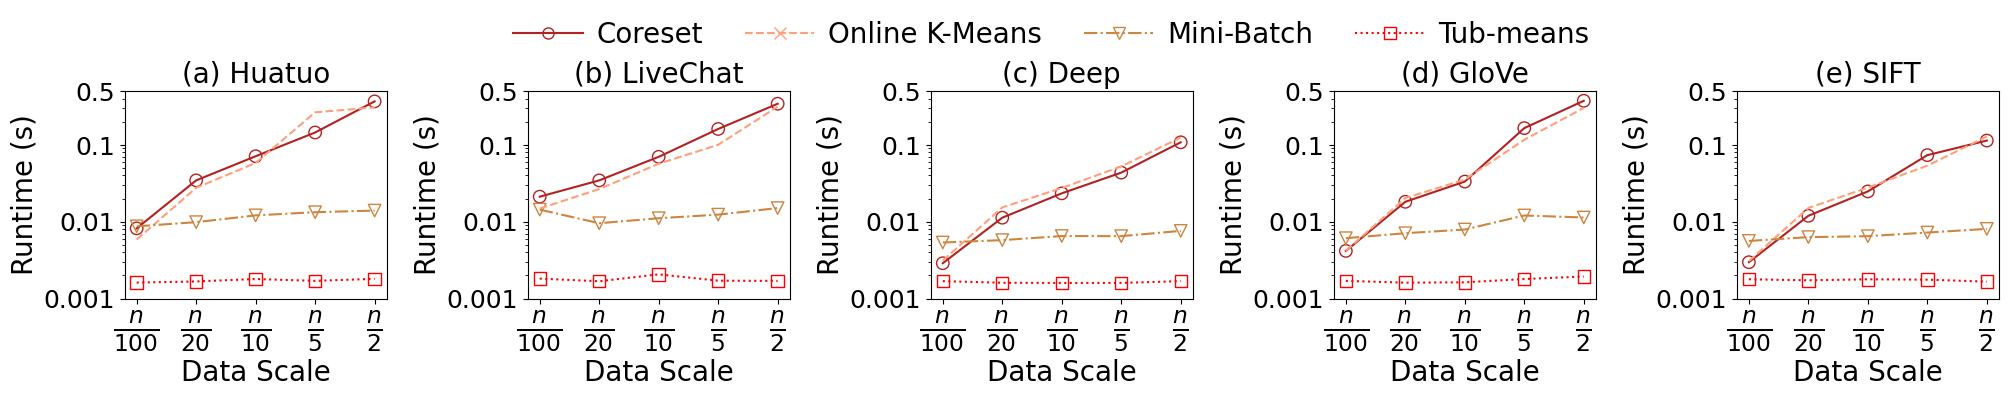

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as mticker

#  LaTeX 
plt.rcParams["text.usetex"] = False

# 
colors = [
    '#B22222',  # firebrick
    '#FFA07A',  # lightsalmon
    '#CD853F',  # peru
    '#FF0000'  # red
]
markers = ["o", "x", "v", "s", "*", "+"]
line_styles = ['-', '--', '-.', ':', '-', '--']
markeredgewidth = 1
fs = 20  # 

# 
df = pd.read_csv('runtime_comparison.csv')  # 

#  (CSV: )
NAME_MAPPING = {
    "Huatuo": "Huatuo",
    "LiveChat": "LiveChat",
    "deep": "Deep",
    "glove": "GloVe",
    "sift": "SIFT"
}

# （CSV）
DATASET_ORDER = ["Huatuo", "LiveChat", "deep", "glove", "sift"]
# 
DISPLAY_ORDER = [NAME_MAPPING[name] for name in DATASET_ORDER]
scales = df['Scale'].unique()
# scales = ['500', '1k', '2k', '5k']


#  - 
fig, axs = plt.subplots(1, len(datasets), figsize=(20, 3.2))
fig.tight_layout(pad=3.0)

# x（LaTeX）
x_positions = [1000, 2000, 3000, 4000, 5000]  # 
x_labels = [
    r"$\frac{n}{100}$",
    r"$\frac{n}{20}$",
    r"$\frac{n}{10}$",
    r"$\frac{n}{5}$",
    r"$\frac{n}{2}$"
]

# （）
# methods = ['Coreset', 'OnlineKMeans', 'MiniBatchKMeans', 'UltraBKNC']
#  (CSV: )
method_mapping = {
    "Coreset": "Coreset",
    "OnlineKMeans": "Online K-Means",
    "MiniBatchKMeans": "Mini-Batch",
    "UltraBKNC": "Tub-means"
}

# （CSV）
original_methods = list(method_mapping.keys())

# 
display_methods = list(method_mapping.values())

# 
for idx, (dataset, display_name) in enumerate(zip(DATASET_ORDER, DISPLAY_ORDER)):
    ax = axs[idx]

    # 
    ax.set_yscale('log')

    # y
    ax.yaxis.set_major_locator(mticker.FixedLocator([0.001, 0.01, 0.1, 1, 10, 100]))
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

    # 
    dataset_data = df[df['Dataset'] == dataset]

    for method_idx, method in enumerate(original_methods):
        # 
        runtimes = dataset_data[method].values

        ax.plot(x_positions, runtimes,
                linestyle=line_styles[method_idx],
                color=colors[method_idx],
                label=method)
        ax.scatter(x_positions, runtimes,
                  marker=markers[method_idx], s=80,
                  edgecolors=colors[method_idx], facecolors='none',
                  linewidths=markeredgewidth)

    # 
    ax.set_title(f"({chr(97+idx)}) {display_name}", fontsize=fs)
    ax.set_xlabel("Data Scale", fontsize=fs)
    ax.set_ylabel("Runtime (s)", fontsize=fs)

    # x
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, fontsize=fs*1.2)

    # y
    ax.set_yticks([0.001, 0.01, 0.1, 0.5])
    ax.set_yticklabels(["0.001", "0.01", "0.1", "0.5"], fontsize=fs*0.9)

#  (，)
handles = []
for idx, method in enumerate(display_methods):
    handle = mlines.Line2D([], [], linestyle=line_styles[idx], color=colors[idx],
                          marker=markers[idx], markersize=8,
                          markerfacecolor='none', markeredgewidth=markeredgewidth,
                          label=method)
    handles.append(handle)

# 
fig.legend(
    handles=handles,
    loc='upper center',
    fontsize=fs,
    bbox_to_anchor=(0.5, 1.15),
    ncol=len(display_methods),
    frameon=False,
    handlelength=2.5,
    handletextpad=0.5,
    columnspacing=1.5
)

# 
plt.subplots_adjust(wspace=0.54, hspace=0.3)

# 
plt.savefig("runtime_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# balanceloss
# switch to TPU!!!
!pip install "jax[tpu]>=0.4.16" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
import jax
import jax.numpy as jnp
import jax.random as jr
from functools import partial
import time
import pandas as pd
from pathlib import Path
from scipy.linalg import orth # For creating orthogonal matrices
import numpy as np
from jax import vmap
import csv
import os
from datetime import datetime

# 
jax.config.update('jax_enable_x64', False)
jax.config.update('jax_default_matmul_precision', 'tensorfloat32')

class UltraBKNC:
    def __init__(self, k=10, lambda_=0.1, niter=25, seed=42, group_size=2):
        self.k = k
        self.lambda_ = lambda_
        self.lambda_reformed = (1-lambda_)/lambda_
        self.niter = niter
        self.seed = seed
        self.dtype = jnp.bfloat16
        self.tpu_tile = 256
        self.runtime_ = None
        self.test_runtime_ = None

        self.sse_ = None
        self.balance_loss_ = None
        self.centroids_ = None

        self.F_ = None  #  F 
        self.Y_ = None  #  Y 
        self.R_ = None  #  R 

        # 
        self._orth = staticmethod(jax.jit(partial(jnp.linalg.qr, mode='reduced')))
        self._svd = staticmethod(jax.jit(partial(jnp.linalg.svd, full_matrices=False)))
        self._matmul = staticmethod(jax.jit(jnp.matmul))

        # 
        self._buffers = None

        self.group_size = group_size

    def _alloc_buffers(self, n_samples):
        """"""
        self._buffers = {
            'F': jnp.empty((n_samples, self.k), dtype=self.dtype),
            'G': jnp.empty((n_samples, self.k), dtype=self.dtype),
            'M': jnp.empty((n_samples, self.k), dtype=self.dtype)  # (n_samples, k)
        }

    def _init_params(self, n_samples):
        """"""
        key = jr.PRNGKey(self.seed)
        keys = jr.split(key, 3)

        # Y
        Y = jax.nn.one_hot(
            jr.randint(keys[0], (n_samples,), 0, self.k),
            self.k, dtype=self.dtype
        )

        # R
        R = self._orth(jr.uniform(keys[1], (self.k, self.k), dtype=self.dtype))[0]
        return Y, R


    @partial(jax.jit, static_argnums=(0,))
    # def predict(self, X_new):
    #     """ F, Y, R  X_new """
    #     X_new = jnp.array(X_new, dtype=self.dtype)
    #     n_new = X_new.shape[0]

    #     #  F_new（）
    #     key = jr.PRNGKey(self.seed)
    #     F_new = self._orth(jr.uniform(key, (n_new, self.k), dtype=self.dtype))[0]

    #     #  Y_new（ R）
    #     P_new = jnp.dot(self.R_.T, F_new.T)  # (k, k) × (k, n_new) → (k, n_new)
    #     Y_new = jax.nn.one_hot(jnp.argmax(P_new, axis=0), self.k, dtype=self.dtype)

    #     # 
    #     labels_new = jnp.argmax(Y_new, axis=1)
    #     return labels_new, F_new, Y_new
    def predict(self, X_new):
        """（）"""
        X_new = jnp.array(X_new, dtype=self.dtype)
        n_new = X_new.shape[0]

        # （）
        key = jr.PRNGKey(self.seed)

        # （）
        start_time = time.time()

        # 1.  F_new 
        F_new = self._orth(jr.uniform(key, (n_new, self.k), dtype=self.dtype))[0]

        # 2.  Y_new = argmax(R^T @ F_new^T)
        P_new = jnp.dot(self.R_.T, F_new.T)  # (k, n_new)
        Y_new = jax.nn.one_hot(jnp.argmax(P_new, axis=0), self.k, dtype=self.dtype)

        # 3. 
        labels_new = jnp.argmax(Y_new, axis=1)

        runtime = time.time() - start_time
        self.test_runtime_ = runtime

        return labels_new, F_new, Y_new

    @partial(jax.jit, static_argnums=(0,))
    def _core_iteration(self, X_m, Y, R, key):
        """"""
        # 1. F
        key, f_key = jr.split(key)
        F = self._buffers['F'].at[:].set(
            self._orth(jr.uniform(f_key, self._buffers['F'].shape, dtype=self.dtype))[0]
        )

        # 2. G
        G = self._buffers['G'].at[:].set(jnp.dot(Y, R.T))  # (n_samples, k)

        # 3. 
        def _inner(F, _):
            XF = jnp.dot(X_m, F)  # (n_features, n_samples) × (n_samples, k) → (n_features, k)
            term1 = 2 * jnp.dot(X_m.T, XF)  # (n_samples, n_features) × (n_features, k) → (n_samples, k)
            term2 = self.lambda_reformed * G  # (n_samples, k)
            M = self._buffers['M'].at[:].set(term1 + term2)  # ，(n_samples, k)
            U, _, Vh = self._svd(M)
            return jnp.dot(U, Vh), None

        F, _ = jax.lax.scan(_inner, F, None, length=3)

        # 4. R
        U_r, _, Vh_r = self._svd(jnp.dot(F.T, Y))  # (k, n_samples) × (n_samples, k) → (k, k)
        R_new = jnp.dot(U_r, Vh_r)

        # 5. Y
        P_calc_Y = jnp.dot(R_new.T, F.T)  # (k, k) × (k, n_samples) → (k, n_samples)
        # Y_new = jax.nn.one_hot(
        #     jnp.argmax(P_calc_Y, axis=0),  # 
        #     self.k, dtype=self.dtype
        # )
        #  P_calc_Y  (num_rows // n, n, k)
        n = self.group_size
        n_samples = P_calc_Y.shape[1]  # 
        # ，
        if n_samples % n != 0:
            pad_size = n - (n_samples % n)
            P_calc_Y = jnp.pad(P_calc_Y, [(0,0), (0,pad_size)])
            n_samples = P_calc_Y.shape[1]
        reshaped_P = P_calc_Y.reshape(-1, n, self.k)

        # n（n）
        product_P = jnp.prod(reshaped_P, axis=1)  #  (num_rows // n, k)

        # 
        max_indices = jnp.argmax(product_P, axis=-1)  #  (num_rows // n,)

        # one-hot
        Y_new = jax.nn.one_hot(
            max_indices,
            self.k,
            dtype=self.dtype
        )

        # （none-hot）
        Y_new_expanded = jnp.repeat(Y_new, n, axis=0)  # P_calc_Y

        # ，
        Y_new_expanded = Y_new_expanded[:P_calc_Y.shape[1]]

        return Y_new_expanded, R_new, key

    def train(self, X):
        # 
        X = jnp.array(X, dtype=self.dtype)
        orig_size = X.shape[0]

        # 
        pad_size = (self.tpu_tile - orig_size % self.tpu_tile) % self.tpu_tile
        X_padded = jnp.pad(X, [(0, pad_size), (0,0)])
        X_m = X_padded.T

        # 
        self._alloc_buffers(X_padded.shape[0])
        Y, R = self._init_params(X_padded.shape[0])
        key = jr.PRNGKey(self.seed)

        # 
        _ = self._core_iteration(X_m, Y, R, key)

        # 
        start = time.time()
        for _ in range(self.niter):
            Y, R, key = self._core_iteration(X_m, Y, R, key)

        self.runtime_ = time.time() - start
        #  F, Y, R
        self.F_ = self._buffers['F'][:orig_size]  # 
        self.Y_ = Y[:orig_size] # 
        self.R_ = R # R  (k, k)，

        self.labels_ = jnp.argmax(Y[:orig_size], axis=1)

        X_original = X[:orig_size]  # 
        labels_np = np.array(self.labels_)  #  NumPy 

        #  centroids_
        centroids = []
        for cluster_idx in range(self.k):
            cluster_points = X_original[labels_np == cluster_idx]  # 
            if len(cluster_points) > 0:
                centroid = np.mean(cluster_points, axis=0)  # 
            else:
                centroid = np.zeros(X_original.shape[1])  #  0
            centroids.append(centroid)
        self.centroids_ = np.array(centroids)  # (k, n_features)

        #  SSE
        sse = 0.0
        for i in range(orig_size):
            cluster_idx = labels_np[i]
            point = X_original[i]
            centroid = self.centroids_[cluster_idx]
            sse += np.sum((point - centroid) ** 2)  # 
        self.sse_ = float(sse)

        #  Balance Loss
        cluster_sizes = np.bincount(labels_np, minlength=self.k)
        ideal_size = orig_size / self.k
        self.balance_loss_ = float(np.sum((cluster_sizes - ideal_size) ** 2))

        return self

def run_experiment(train_path, test_path, dimensions, n_clusters, group_size):
    """：+，"""
    # 1.  (10K)
    X_train = pd.read_csv(train_path, header=None).values.astype(jnp.float32)

    # 2. （10K）
    model = UltraBKNC(k=n_clusters, lambda_=0.1, niter=10, seed=42, group_size=group_size)
    model.train(X_train)  # SSEBalance Loss

    # 3.  (1K)
    X_test = pd.read_csv(test_path, header=None).values.astype(jnp.float32)

    # 4. 
    test_labels, _, _ = model.predict(X_test)

    # 5. Balance Loss（+）
    combined_cluster_sizes = (
        np.bincount(model.labels_, minlength=n_clusters) +
        np.bincount(test_labels, minlength=n_clusters))
    total_samples = X_train.shape[0] + X_test.shape[0]
    ideal_size_total = total_samples / n_clusters
    total_balance_loss = np.sum((combined_cluster_sizes - ideal_size_total) ** 2)

    return {
        "total_balance_loss": float(total_balance_loss),
        "cluster_distribution": combined_cluster_sizes.tolist()
    }

if __name__ == '__main__':
    # 
    DATASET_ORDER = ['Huatuo', 'LiveChat', 'deep', 'glove', 'sift']
    SIZE_ORDER = ['100', '500', '1k', '2k', '5k']

    #  (10K)  (1K) 
    datasets = [
        {
            "name": "Huatuo",
            "train": "/content/sample_data/Huatuo_1024d_10k.csv",
            "test1": "/content/sample_data/Huatuo_1024d_100.csv",
            "test2": "/content/sample_data/Huatuo_1024d_500.csv",
            "test3": "/content/sample_data/Huatuo_1024d_1k.csv",
            "test4": "/content/sample_data/Huatuo_1024d_2k.csv",
            "test5": "/content/sample_data/Huatuo_1024d_5k.csv",
            "dim": 1024
        },
        {
            "name": "LiveChat",
            "train": "/content/sample_data/LiveChat_1024d_10k.csv",
            "test1": "/content/sample_data/LiveChat_1024d_100.csv",
            "test2": "/content/sample_data/LiveChat_1024d_500.csv",
            "test3": "/content/sample_data/LiveChat_1024d_1k.csv",
            "test4": "/content/sample_data/LiveChat_1024d_2k.csv",
            "test5": "/content/sample_data/LiveChat_1024d_5k.csv",
            "dim": 1024
        },
        {
            "name": "deep",
            "train": "/content/sample_data/deep_96d_10k.csv",
            "test1": "/content/sample_data/deep_96d_100.csv",
            "test2": "/content/sample_data/deep_96d_500.csv",
            "test3": "/content/sample_data/deep_96d_1k.csv",
            "test4": "/content/sample_data/deep_96d_2k.csv",
            "test5": "/content/sample_data/deep_96d_5k.csv",
            "dim": 96
        },
        {
            "name": "glove",
            "train": "/content/sample_data/glove_300d_10k.csv",
            "test1": "/content/sample_data/glove_300d_100.csv",
            "test2": "/content/sample_data/glove_300d_500.csv",
            "test3": "/content/sample_data/glove_300d_1k.csv",
            "test4": "/content/sample_data/glove_300d_2k.csv",
            "test5": "/content/sample_data/glove_300d_5k.csv",
            "dim": 300
        },
        {
            "name": "sift",
            "train": "/content/sample_data/sift_128d_10k.csv",
            "test1": "/content/sample_data/sift_128d_100.csv",
            "test2": "/content/sample_data/sift_128d_500.csv",
            "test3": "/content/sample_data/sift_128d_1k.csv",
            "test4": "/content/sample_data/sift_128d_2k.csv",
            "test5": "/content/sample_data/sift_128d_5k.csv",
            "dim": 128
        }
    ]
    group_size = 8

    # CSV（）
    csv_file = 'balance_loss_comparison.csv'
    results = []
    if os.path.exists(csv_file):
        with open(csv_file, mode='r') as f:
            reader = csv.reader(f)
            headers = next(reader)
            results = list(reader)

    # （）
    if len(headers) == 5:
        headers.append('UltraBKNC')

    # UltraBKNC
    for i, row in enumerate(results):
        dataset = row[0]
        size = row[1]

        print(f"\n=== :  {dataset},  {size} ===")

        # 
        test_key = {
            '100': 'test1',
            '500': 'test2',
            '1k': 'test3',
            '2k': 'test4',
            '5k': 'test5'
        }.get(size)

        if not test_key:
            row.append('N/A')
            continue

        # 
        ds_config = next((d for d in datasets if d['name'] == dataset), None)
        if not ds_config:
            row.append('N/A')
            continue

        # UltraBKNC
        test_path = ds_config[test_key]
        if not os.path.exists(test_path):
            row.append('File not found')
            continue

        try:
            # 
            metrics = run_experiment(
                train_path=ds_config["train"],
                test_path=test_path,
                dimensions=ds_config["dim"],
                n_clusters=10,
                group_size=group_size
            )

            # 
            if len(row) == 5:
                row.extend([
                    f"{metrics['total_balance_loss']:.4f}",
                ])
            else:
                row[5] = f"{metrics['total_balance_loss']:.4f}"

            print(f": {metrics['total_balance_loss']:.2f}")

        except Exception as e:
            print(f": {str(e)}")
            row.extend([f"Error: {str(e)}"])

    # CSV
    with open(csv_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(headers)
        writer.writerows(results)

    print(f"\n {csv_file}，UltraBKNC")

Looking in links: https://storage.googleapis.com/jax-releases/libtpu_releases.html

=== :  Huatuo,  100 ===
: 95865.60

=== :  Huatuo,  500 ===
: 100621.60

=== :  Huatuo,  1k ===
: 113901.60

=== :  Huatuo,  2k ===
: 151091.60

=== :  Huatuo,  5k ===
: 318921.60

=== :  LiveChat,  100 ===
: 55775.60

=== :  LiveChat,  500 ===
: 53537.60

=== :  LiveChat,  1k ===
: 58059.60

=== :  LiveChat,  2k ===
: 76239.60

=== :  LiveChat,  5k ===
: 217003.60

=== :  deep,  100 ===
: 82389.60

=== :  deep,  500 ===
: 96341.60

=== :  deep,  1k ===
: 113235.60

=== :  deep,  2k ===
: 155571.60

=== :  deep,  5k ===
: 344867.60

=== :  glove,  100 ===
: 33703.60

=== :  glove,  500 ===
: 39443.60

=== :  glove,  1k ===
: 51409.60

=== :  glove,  2k ===
: 82381.60

=== :  glove,  5k ===
: 273203.60

=== :  sift,  100 ===
: 205870.90

=== :  sift,  500 ===
: 192946.90

=== :  sift,  1k ===
: 175350.90

=== :  sift,  2k ===
: 172280.90

=== :  sift,  5k ===
: 265832.90

 balance_loss_comparison.csv，Ult

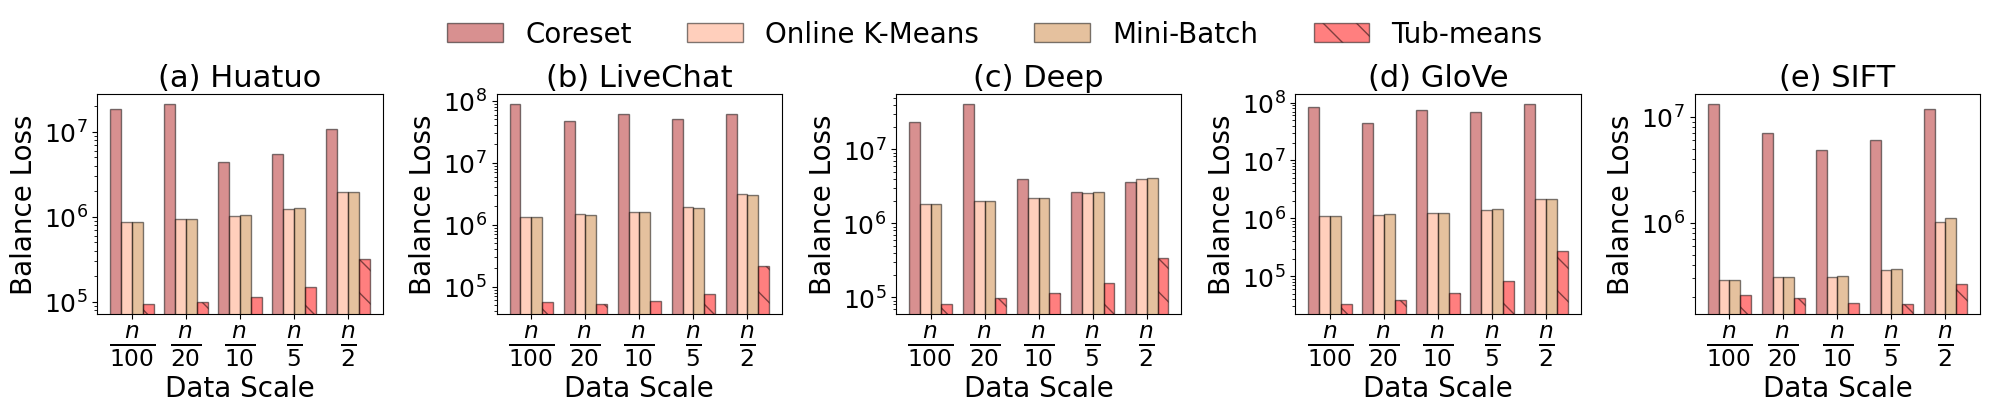

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerPatch


#  LaTeX 
plt.rcParams["text.usetex"] = False

# CSV（CSV：Dataset, Scale, Method1_SSE, Method2_SSE, Method3_SSE, Method4_SSE）
data = pd.read_csv('balance_loss_comparison.csv')

# （4）
colors = [
    '#B22222',  # firebrick
    '#FFA07A',  # lightsalmon
    '#CD853F',  # peru
    '#FF0000'  # red
]
hatches = [None, None, None, '\\']  # 4

# 
# method_labels = ["Coreset", "OnlineKMeans", "MiniBatch", "UltraBKNC"]
#  (CSV: )
method_mapping = {
    "Coreset": "Coreset",
    "OnlineKMeans": "Online K-Means",
    "MiniBatch": "Mini-Batch",
    "UltraBKNC": "Tub-means"
}

# （CSV）
original_methods = list(method_mapping.keys())

# 
display_methods = list(method_mapping.values())

# 
# scale_labels = ['500', '1k', '2k', '5k']
scale_mapping = {
    '100': r"$\frac{n}{100}$",
    '500': r"$\frac{n}{20}$",
    '1k': r"$\frac{n}{10}$",
    '2k': r"$\frac{n}{5}$",
    '5k': r"$\frac{n}{2}$"
}

# scale
actual_scales = list(scale_mapping.keys())
display_labels = list(scale_mapping.values())

# （）
dataset_labels = ['Huatuo', 'LiveChat', 'deep', 'glove', 'sift']
titles = ["(a) Huatuo", "(b) LiveChat", "(c) Deep", "(d) GloVe", "(e) SIFT"]

# 
fs = 20

# 
fig, axs = plt.subplots(1, 5, figsize=(20, 3.8))
axs = axs.flatten()

# 
x = np.arange(len(actual_scales))  # 4
width = 0.2  # 

for i, dataset in enumerate(dataset_labels):
    ax = axs[i]

    # 
    dataset_data = data[data['Dataset'] == dataset]

    # 
    for j, method in enumerate(original_methods):
        # SSE
        sse_values = []
        for scale in actual_scales:
            scale_data = dataset_data[dataset_data['Scale'] == scale]
            if not scale_data.empty:
                # CSV
                if method == "UltraBKNC":
                    sse = scale_data.iloc[0, 5]  # UltraBKNC5
                else:
                    sse = scale_data[f"{method}"].values[0]  # SSE
                sse_values.append(float(sse))
            else:
                sse_values.append(0)

        # 
        bars = ax.bar(x + j*width, sse_values, width,
                     color=colors[j], edgecolor='black', alpha=0.5,
                     hatch=hatches[j],  # 
                     label=display_methods[j] if i == 0 else "")

    # 
    ax.set_xlabel('Data Scale', fontsize=fs)
    ax.set_ylabel('Balance Loss', fontsize=fs)
    ax.set_title(titles[i], fontsize=fs+2)
    ax.set_xticks(x + width*1.5)
    ax.set_xticklabels(display_labels, fontsize=fs*1.2)

    # y（SSE）
    ax.set_yscale('log')
    ax.tick_params(axis='y', labelsize=fs*0.9)


# 
handles = [Rectangle((0,0), 1, 1, color=colors[i], hatch=hatches[i], ec='k', alpha=0.5)
           for i in range(len(display_methods))]
fig.legend(handles, display_methods,
           loc='upper center',
           bbox_to_anchor=(0.5, 1.11),
           ncol=4,
           fontsize=fs,
           frameon=False)

# 
plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.4)

# 
plt.savefig("balance_loss_comparison.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# clusteringloss
# switch to TPU!!!
!pip install "jax[tpu]>=0.4.16" -f https://storage.googleapis.com/jax-releases/libtpu_releases.html
import jax
import jax.numpy as jnp
import jax.random as jr
from functools import partial
import time
import pandas as pd
from pathlib import Path
from scipy.linalg import orth # For creating orthogonal matrices
import numpy as np
from jax import vmap
import csv
import os
from datetime import datetime

# 
jax.config.update('jax_enable_x64', False)
jax.config.update('jax_default_matmul_precision', 'tensorfloat32')

class UltraBKNC:
    def __init__(self, k=10, lambda_=0.1, niter=25, seed=42, group_size=2):
        self.k = k
        self.lambda_ = lambda_
        self.lambda_reformed = (1-lambda_)/lambda_
        self.niter = niter
        self.seed = seed
        self.dtype = jnp.bfloat16
        self.tpu_tile = 256
        self.runtime_ = None
        self.test_runtime_ = None

        self.sse_ = None
        self.balance_loss_ = None
        self.centroids_ = None

        self.F_ = None  #  F 
        self.Y_ = None  #  Y 
        self.R_ = None  #  R 

        # 
        self._orth = staticmethod(jax.jit(partial(jnp.linalg.qr, mode='reduced')))
        self._svd = staticmethod(jax.jit(partial(jnp.linalg.svd, full_matrices=False)))
        self._matmul = staticmethod(jax.jit(jnp.matmul))

        # 
        self._buffers = None

        self.group_size = group_size

    def _alloc_buffers(self, n_samples):
        """"""
        self._buffers = {
            'F': jnp.empty((n_samples, self.k), dtype=self.dtype),
            'G': jnp.empty((n_samples, self.k), dtype=self.dtype),
            'M': jnp.empty((n_samples, self.k), dtype=self.dtype)  # (n_samples, k)
        }

    def _init_params(self, n_samples):
        """"""
        key = jr.PRNGKey(self.seed)
        keys = jr.split(key, 3)

        # Y
        Y = jax.nn.one_hot(
            jr.randint(keys[0], (n_samples,), 0, self.k),
            self.k, dtype=self.dtype
        )

        # R
        R = self._orth(jr.uniform(keys[1], (self.k, self.k), dtype=self.dtype))[0]
        return Y, R


    @partial(jax.jit, static_argnums=(0,))
    # def predict(self, X_new):
    #     """ F, Y, R  X_new """
    #     X_new = jnp.array(X_new, dtype=self.dtype)
    #     n_new = X_new.shape[0]

    #     #  F_new（）
    #     key = jr.PRNGKey(self.seed)
    #     F_new = self._orth(jr.uniform(key, (n_new, self.k), dtype=self.dtype))[0]

    #     #  Y_new（ R）
    #     P_new = jnp.dot(self.R_.T, F_new.T)  # (k, k) × (k, n_new) → (k, n_new)
    #     Y_new = jax.nn.one_hot(jnp.argmax(P_new, axis=0), self.k, dtype=self.dtype)

    #     # 
    #     labels_new = jnp.argmax(Y_new, axis=1)
    #     return labels_new, F_new, Y_new
    def predict(self, X_new):
        """（）"""
        X_new = jnp.array(X_new, dtype=self.dtype)
        n_new = X_new.shape[0]

        # （）
        key = jr.PRNGKey(self.seed)

        # （）
        start_time = time.time()

        # 1.  F_new 
        F_new = self._orth(jr.uniform(key, (n_new, self.k), dtype=self.dtype))[0]

        # 2.  Y_new = argmax(R^T @ F_new^T)
        P_new = jnp.dot(self.R_.T, F_new.T)  # (k, n_new)
        Y_new = jax.nn.one_hot(jnp.argmax(P_new, axis=0), self.k, dtype=self.dtype)

        # 3. 
        labels_new = jnp.argmax(Y_new, axis=1)

        runtime = time.time() - start_time
        self.test_runtime_ = runtime

        return labels_new, F_new, Y_new

    @partial(jax.jit, static_argnums=(0,))
    def _core_iteration(self, X_m, Y, R, key):
        """"""
        # 1. F
        key, f_key = jr.split(key)
        F = self._buffers['F'].at[:].set(
            self._orth(jr.uniform(f_key, self._buffers['F'].shape, dtype=self.dtype))[0]
        )

        # 2. G
        G = self._buffers['G'].at[:].set(jnp.dot(Y, R.T))  # (n_samples, k)

        # 3. 
        def _inner(F, _):
            XF = jnp.dot(X_m, F)  # (n_features, n_samples) × (n_samples, k) → (n_features, k)
            term1 = 2 * jnp.dot(X_m.T, XF)  # (n_samples, n_features) × (n_features, k) → (n_samples, k)
            term2 = self.lambda_reformed * G  # (n_samples, k)
            M = self._buffers['M'].at[:].set(term1 + term2)  # ，(n_samples, k)
            U, _, Vh = self._svd(M)
            return jnp.dot(U, Vh), None

        F, _ = jax.lax.scan(_inner, F, None, length=3)

        # 4. R
        U_r, _, Vh_r = self._svd(jnp.dot(F.T, Y))  # (k, n_samples) × (n_samples, k) → (k, k)
        R_new = jnp.dot(U_r, Vh_r)

        # 5. Y
        P_calc_Y = jnp.dot(R_new.T, F.T)  # (k, k) × (k, n_samples) → (k, n_samples)
        # Y_new = jax.nn.one_hot(
        #     jnp.argmax(P_calc_Y, axis=0),  # 
        #     self.k, dtype=self.dtype
        # )
        #  P_calc_Y  (num_rows // n, n, k)
        n = self.group_size
        n_samples = P_calc_Y.shape[1]  # 
        # ，
        if n_samples % n != 0:
            pad_size = n - (n_samples % n)
            P_calc_Y = jnp.pad(P_calc_Y, [(0,0), (0,pad_size)])
            n_samples = P_calc_Y.shape[1]
        reshaped_P = P_calc_Y.reshape(-1, n, self.k)

        # n（n）
        product_P = jnp.prod(reshaped_P, axis=1)  #  (num_rows // n, k)

        # 
        max_indices = jnp.argmax(product_P, axis=-1)  #  (num_rows // n,)

        # one-hot
        Y_new = jax.nn.one_hot(
            max_indices,
            self.k,
            dtype=self.dtype
        )

        # （none-hot）
        Y_new_expanded = jnp.repeat(Y_new, n, axis=0)  # P_calc_Y

        # ，
        Y_new_expanded = Y_new_expanded[:P_calc_Y.shape[1]]

        return Y_new_expanded, R_new, key

    def train(self, X):
        # 
        X = jnp.array(X, dtype=self.dtype)
        orig_size = X.shape[0]

        # 
        pad_size = (self.tpu_tile - orig_size % self.tpu_tile) % self.tpu_tile
        X_padded = jnp.pad(X, [(0, pad_size), (0,0)])
        X_m = X_padded.T

        # 
        self._alloc_buffers(X_padded.shape[0])
        Y, R = self._init_params(X_padded.shape[0])
        key = jr.PRNGKey(self.seed)

        # 
        _ = self._core_iteration(X_m, Y, R, key)

        # 
        start = time.time()
        for _ in range(self.niter):
            Y, R, key = self._core_iteration(X_m, Y, R, key)

        self.runtime_ = time.time() - start
        #  F, Y, R
        self.F_ = self._buffers['F'][:orig_size]  # 
        self.Y_ = Y[:orig_size] # 
        self.R_ = R # R  (k, k)，

        self.labels_ = jnp.argmax(Y[:orig_size], axis=1)

        X_original = X[:orig_size]  # 
        labels_np = np.array(self.labels_)  #  NumPy 

        #  centroids_
        centroids = []
        for cluster_idx in range(self.k):
            cluster_points = X_original[labels_np == cluster_idx]  # 
            if len(cluster_points) > 0:
                centroid = np.mean(cluster_points, axis=0)  # 
            else:
                centroid = np.zeros(X_original.shape[1])  #  0
            centroids.append(centroid)
        self.centroids_ = np.array(centroids)  # (k, n_features)

        #  SSE
        sse = 0.0
        for i in range(orig_size):
            cluster_idx = labels_np[i]
            point = X_original[i]
            centroid = self.centroids_[cluster_idx]
            sse += np.sum((point - centroid) ** 2)  # 
        self.sse_ = float(sse)

        #  Balance Loss
        cluster_sizes = np.bincount(labels_np, minlength=self.k)
        ideal_size = orig_size / self.k
        self.balance_loss_ = float(np.sum((cluster_sizes - ideal_size) ** 2))

        return self

def run_experiment(train_path, test_path, dimensions, n_clusters, group_size):
    """：+，SSE"""
    # 1.  (10K)
    X_train = pd.read_csv(train_path, header=None).values.astype(jnp.float32)

    # 2. （10K）
    model = UltraBKNC(k=n_clusters, lambda_=0.1, niter=10, seed=42, group_size=group_size)
    model.train(X_train)

    # 3. 
    X_test = pd.read_csv(test_path, header=None).values.astype(jnp.float32)

    # 4. 
    test_labels, _, _ = model.predict(X_test)

    # 5. SSE
    sse_test = 0.0
    for i in range(X_test.shape[0]):
        cluster_idx = test_labels[i]
        point = X_test[i]
        centroid = model.centroids_[cluster_idx]
        sse_test += jnp.sum((point - centroid) ** 2)

    return float(model.sse_ + sse_test)  # SSE

if __name__ == '__main__':
    # 
    DATASET_ORDER = ['Huatuo', 'LiveChat', 'deep', 'glove', 'sift']
    SIZE_ORDER = ['100', '500', '1k', '2k', '5k']

    #  (10K)  (1K) 
    datasets = [
        {
            "name": "Huatuo",
            "train": "/content/sample_data/Huatuo_1024d_10k.csv",
            "test1": "/content/sample_data/Huatuo_1024d_100.csv",
            "test2": "/content/sample_data/Huatuo_1024d_500.csv",
            "test3": "/content/sample_data/Huatuo_1024d_1k.csv",
            "test4": "/content/sample_data/Huatuo_1024d_2k.csv",
            "test5": "/content/sample_data/Huatuo_1024d_5k.csv",
            "dim": 1024
        },
        {
            "name": "LiveChat",
            "train": "/content/sample_data/LiveChat_1024d_10k.csv",
            "test1": "/content/sample_data/LiveChat_1024d_100.csv",
            "test2": "/content/sample_data/LiveChat_1024d_500.csv",
            "test3": "/content/sample_data/LiveChat_1024d_1k.csv",
            "test4": "/content/sample_data/LiveChat_1024d_2k.csv",
            "test5": "/content/sample_data/LiveChat_1024d_5k.csv",
            "dim": 1024
        },
        {
            "name": "deep",
            "train": "/content/sample_data/deep_96d_10k.csv",
            "test1": "/content/sample_data/deep_96d_100.csv",
            "test2": "/content/sample_data/deep_96d_500.csv",
            "test3": "/content/sample_data/deep_96d_1k.csv",
            "test4": "/content/sample_data/deep_96d_2k.csv",
            "test5": "/content/sample_data/deep_96d_5k.csv",
            "dim": 96
        },
        {
            "name": "glove",
            "train": "/content/sample_data/glove_300d_10k.csv",
            "test1": "/content/sample_data/glove_300d_100.csv",
            "test2": "/content/sample_data/glove_300d_500.csv",
            "test3": "/content/sample_data/glove_300d_1k.csv",
            "test4": "/content/sample_data/glove_300d_2k.csv",
            "test5": "/content/sample_data/glove_300d_5k.csv",
            "dim": 300
        },
        {
            "name": "sift",
            "train": "/content/sample_data/sift_128d_10k.csv",
            "test1": "/content/sample_data/sift_128d_100.csv",
            "test2": "/content/sample_data/sift_128d_500.csv",
            "test3": "/content/sample_data/sift_128d_1k.csv",
            "test4": "/content/sample_data/sift_128d_2k.csv",
            "test5": "/content/sample_data/sift_128d_5k.csv",
            "dim": 128
        }
    ]
    group_size = 8

    # CSV（）
    csv_file = 'sse_comparison.csv'
    results = []
    if os.path.exists(csv_file):
        with open(csv_file, mode='r') as f:
            reader = csv.reader(f)
            headers = next(reader)
            results = list(reader)

    # （）
    if len(headers) == 5:
        headers.append('UltraBKNC')

    # UltraBKNC
    for i, row in enumerate(results):
        dataset = row[0]
        size = row[1]

        print(f"\n=== :  {dataset},  {size} ===")

        # 
        test_key = {
            '100': 'test1',
            '500': 'test2',
            '1k': 'test3',
            '2k': 'test4',
            '5k': 'test5'
        }.get(size)

        if not test_key:
            row.append('N/A')
            continue

        # 
        ds_config = next((d for d in datasets if d['name'] == dataset), None)
        if not ds_config:
            row.append('N/A')
            continue

        # UltraBKNC
        test_path = ds_config[test_key]
        if not os.path.exists(test_path):
            row.append('File not found')
            continue

        try:
            # 
            total_sse = run_experiment(
                train_path=ds_config["train"],
                test_path=test_path,
                dimensions=ds_config["dim"],
                n_clusters=10,
                group_size=group_size
            )

            # 5
            if len(row) == 5:
                row.append(f"{total_sse:.4f}")
            else:
                row[5] = f"{total_sse:.4f}"

            print(f"{dataset} {size}: SSE = {total_sse:.2f}")

        except Exception as e:
            print(f": {str(e)}")
            row.extend([f"Error: {str(e)}"])

    # CSV
    with open(csv_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(headers)
        writer.writerows(results)

    print(f"\n {csv_file}，UltraBKNC")

Looking in links: https://storage.googleapis.com/jax-releases/libtpu_releases.html

=== :  Huatuo,  100 ===
Huatuo 100: SSE = 245.25

=== :  Huatuo,  500 ===
Huatuo 500: SSE = 369.76

=== :  Huatuo,  1k ===
Huatuo 1k: SSE = 526.93

=== :  Huatuo,  2k ===
Huatuo 2k: SSE = 839.83

=== :  Huatuo,  5k ===
Huatuo 5k: SSE = 1782.29

=== :  LiveChat,  100 ===
LiveChat 100: SSE = 149.21

=== :  LiveChat,  500 ===
LiveChat 500: SSE = 229.67

=== :  LiveChat,  1k ===
LiveChat 1k: SSE = 331.00

=== :  LiveChat,  2k ===
LiveChat 2k: SSE = 535.00

=== :  LiveChat,  5k ===
LiveChat 5k: SSE = 1147.29

=== :  deep,  100 ===
deep 100: SSE = 606.02

=== :  deep,  500 ===
deep 500: SSE = 976.54

=== :  deep,  1k ===
deep 1k: SSE = 1438.91

=== :  deep,  2k ===
deep 2k: SSE = 2369.86

=== :  deep,  5k ===
deep 5k: SSE = 5168.06

=== :  glove,  100 ===
glove 100: SSE = 38981.23

=== :  glove,  500 ===
glove 500: SSE = 56184.58

=== :  glove,  1k ===
glove 1k: SSE = 77984.42

=== :  glove,  2k ===
glove 2k:

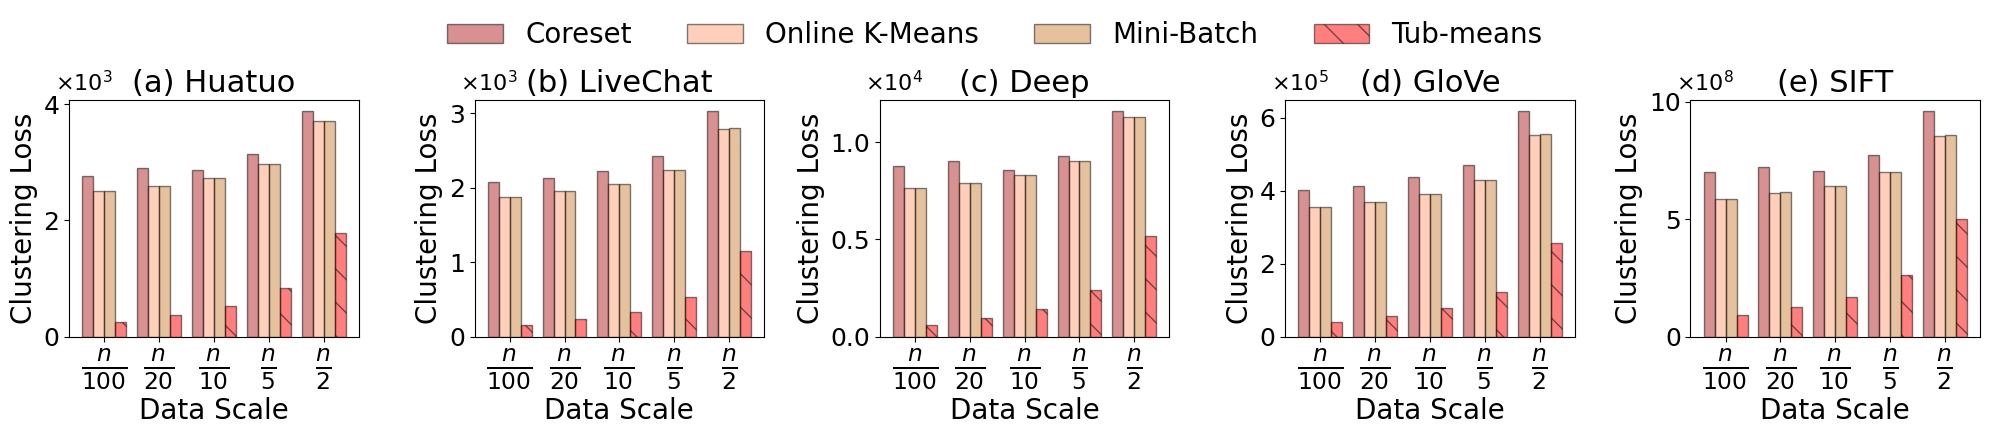

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerPatch
import math

#  LaTeX 
plt.rcParams["text.usetex"] = False

# CSV
data = pd.read_csv('sse_comparison.csv')

# （4）
colors = [
    '#B22222',  # firebrick
    '#FFA07A',  # lightsalmon
    '#CD853F',  # peru
    '#FF0000'  # red
]
hatches = [None, None, None, '\\']  # 4

# 
# method_labels = ["Coreset", "OnlineKMeans", "MiniBatch", "UltraBKNC"]
#  (CSV: )
method_mapping = {
    "Coreset": "Coreset",
    "OnlineKMeans": "Online K-Means",
    "MiniBatch": "Mini-Batch",
    "UltraBKNC": "Tub-means"
}

# （CSV）
original_methods = list(method_mapping.keys())

# 
display_methods = list(method_mapping.values())

# 
# scale_labels = ['500', '1k', '2k', '5k']
scale_mapping = {
    '100': r"$\frac{n}{100}$",
    '500': r"$\frac{n}{20}$",
    '1k': r"$\frac{n}{10}$",
    '2k': r"$\frac{n}{5}$",
    '5k': r"$\frac{n}{2}$"
}

# scale
actual_scales = list(scale_mapping.keys())
display_labels = list(scale_mapping.values())

# 
dataset_labels = ['Huatuo', 'LiveChat', 'deep', 'glove', 'sift']
titles = ["(a) Huatuo", "(b) LiveChat", "(c) Deep", "(d) GloVe", "(e) SIFT"]

# 
fs = 20

# 
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
axs = axs.flatten()

# 
x = np.arange(len(actual_scales))
width = 0.2

for i, dataset in enumerate(dataset_labels):
    ax = axs[i]
    dataset_data = data[data['Dataset'] == dataset]

    # SSE
    all_sse = []
    for j, method in enumerate(original_methods):
        for scale in actual_scales:
            scale_data = dataset_data[dataset_data['Scale'] == scale]
            if not scale_data.empty:
                if method == "UltraBKNC":
                    sse = scale_data.iloc[0, 5]
                else:
                    sse = scale_data[f"{method}"].values[0]
                all_sse.append(float(sse))

    # 
    max_sse = max(all_sse) if all_sse else 1
    exponent = int(math.floor(math.log10(max_sse))) if max_sse > 0 else 0
    base = 10 ** exponent

    for j, method in enumerate(original_methods):
        sse_values = []
        for scale in actual_scales:
            scale_data = dataset_data[dataset_data['Scale'] == scale]
            if not scale_data.empty:
                if method == "UltraBKNC":
                    sse = scale_data.iloc[0, 5]
                else:
                    sse = scale_data[f"{method}"].values[0]
                sse_values.append(float(sse)/base)  # 
            else:
                sse_values.append(0)

        # （）
        bars = ax.bar(x + j*width, sse_values, width,
                     color=colors[j], edgecolor='black', alpha=0.5,
                     hatch=hatches[j],  # 
                     label=display_methods[j] if i == 0 else "")

    # 
    ax.set_xlabel('Data Scale', fontsize=fs)
    ax.set_ylabel('Clustering Loss', fontsize=fs)
    ax.set_title(titles[i], fontsize=fs+2)
    ax.set_xticks(x + width*1.5)
    ax.set_xticklabels(display_labels, fontsize=fs*1.2)

    # y（）
    ax.set_yscale('linear')
    ax.tick_params(axis='y', labelsize=fs*0.9)

    # 
    if exponent != 0:
        ax.annotate(r'$\times 10^{%d}$' % exponent,
                   xy=(-0.05, 1.02), xycoords='axes fraction',
                   fontsize=fs*0.8, ha='left', va='bottom')

# 
handles = [Rectangle((0,0), 1, 1, color=colors[i], hatch=hatches[i], ec='k', alpha=0.5)
           for i in range(len(display_methods))]
fig.legend(handles, display_methods,
           loc='upper center',
           bbox_to_anchor=(0.5, 1.11),
           ncol=4,
           fontsize=fs,
           frameon=False)

# 
plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.4)

# 
plt.savefig("sse_comparison.pdf", bbox_inches='tight', dpi=300)
plt.show()